In [1]:
#import Libraries
from __future__ import print_function, division
%matplotlib notebook
import brainweb
from brainweb import volshow
import numpy as np
from os import path
from tqdm.auto import tqdm
import logging
logging.basicConfig(level=logging.INFO)
import nibabel as nib
import sirf.STIR as pet
import matplotlib.pyplot as plt
import os
import sirf.Reg as reg
from math import cos, sin, pi
from sirf.Utilities import examples_data_path
import shutil
from scipy.ndimage.filters import gaussian_filter
from sirf.Gadgetron import *
from cil.plugins.ccpi_regularisation.functions import FGP_dTV

In [2]:
data_path = path.join(examples_data_path('Synergistic'), 'brainweb')
if not path.isdir(data_path):
    os.makedirs(data_path)
os.chdir(data_path)

fname, url= sorted(brainweb.utils.LINKS.items())[0]
files = brainweb.get_file(fname, url, ".")
data = brainweb.load_file(fname)

brainweb.seed(1337)

for f in tqdm([fname], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(
        f,
        petNoise=1, t1Noise=0.75, t2Noise=0.75,
        petSigma=1, t1Sigma=1, t2Sigma=1)
    vol_amyl = brainweb.get_mmr_fromfile(
        f,
        petNoise=1, t1Noise=0.75, t2Noise=0.75,
        petSigma=1, t1Sigma=1, t2Sigma=1,
        PetClass=brainweb.Amyloid)

FDG_arr  = vol['PET']
amyl_arr = vol_amyl['PET']
uMap_arr = vol['uMap']
T1_arr   = vol['T1']
T2_arr   = vol['T2']

mMR ground truths:   0%|          | 0/1 [00:00<?, ?subject/s]

<IPython.core.display.Javascript object>


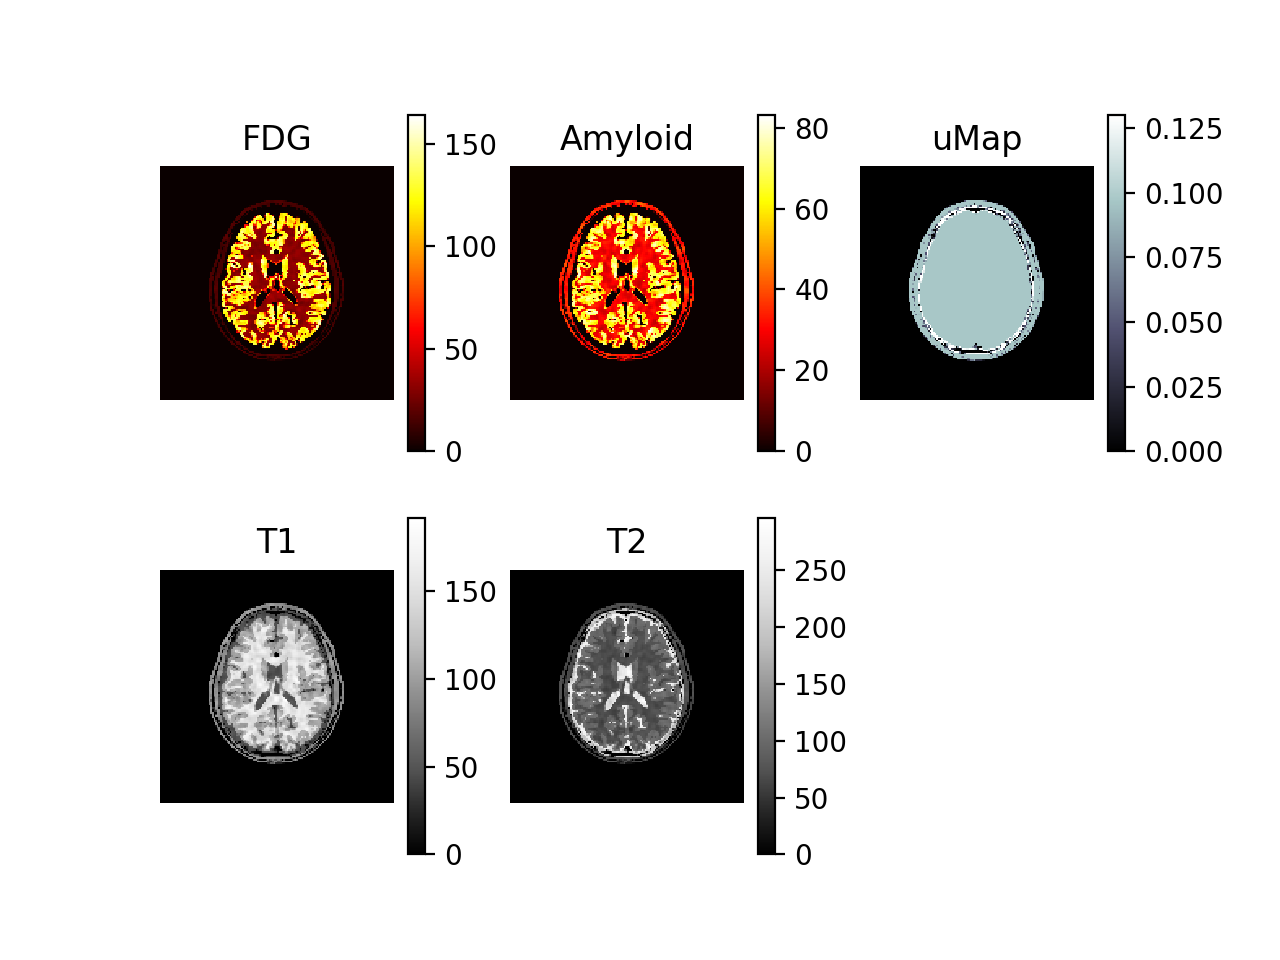

In [3]:
def subplot_(idx,vol,title,clims=None,cmap="viridis"):
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar()
    plt.title(title)
    plt.axis("off")

plt.figure();
slice_show = FDG_arr.shape[0]//2
subplot_([2,3,1],FDG_arr [slice_show, 100:-100, 100:-100],'FDG'    ,cmap="hot")
subplot_([2,3,2],amyl_arr[slice_show, 100:-100, 100:-100],'Amyloid',cmap="hot")
subplot_([2,3,3],uMap_arr[slice_show, 100:-100, 100:-100],'uMap'   ,cmap="bone")
subplot_([2,3,4],T1_arr  [slice_show, 100:-100, 100:-100],'T1'     ,cmap="Greys_r")
subplot_([2,3,5],T2_arr  [slice_show, 100:-100, 100:-100],'T2'     ,cmap="Greys_r")

In [4]:
mMR_template_sino = examples_data_path('PET') + "/mMR/mMR_template_span11.hs"
templ_sino = pet.AcquisitionData(mMR_template_sino)

def crop_and_save(templ_sino, vol, fname):
    # Crop from (127,344,344) to (127,285,285) and save to file
    vol = vol[:,17:17+285,17:17+285]
    im = pet.ImageData(templ_sino)
    im.fill(vol)
    im.write(fname)
    # Create an optional smaller version, (127,150,150)
    # For extra speeeed.
    # Also shift by (25,25) in (x,y) to recentre the image
    im = im.zoom_image(size=(-1,150,150),offsets_in_mm=(0,25,25))
    im = im.move_to_scanner_centre(templ_sino)
    im.write(fname + "_small.hv")
    return im
    
FDG  = crop_and_save(templ_sino, FDG_arr,  "FDG"    )
amyl = crop_and_save(templ_sino, amyl_arr, "Amyloid")
uMap = crop_and_save(templ_sino, uMap_arr, "uMap"   )
T1   = crop_and_save(templ_sino, T1_arr,   "T1"     )
T2   = crop_and_save(templ_sino, T2_arr,   "T2"     )

<IPython.core.display.Javascript object>


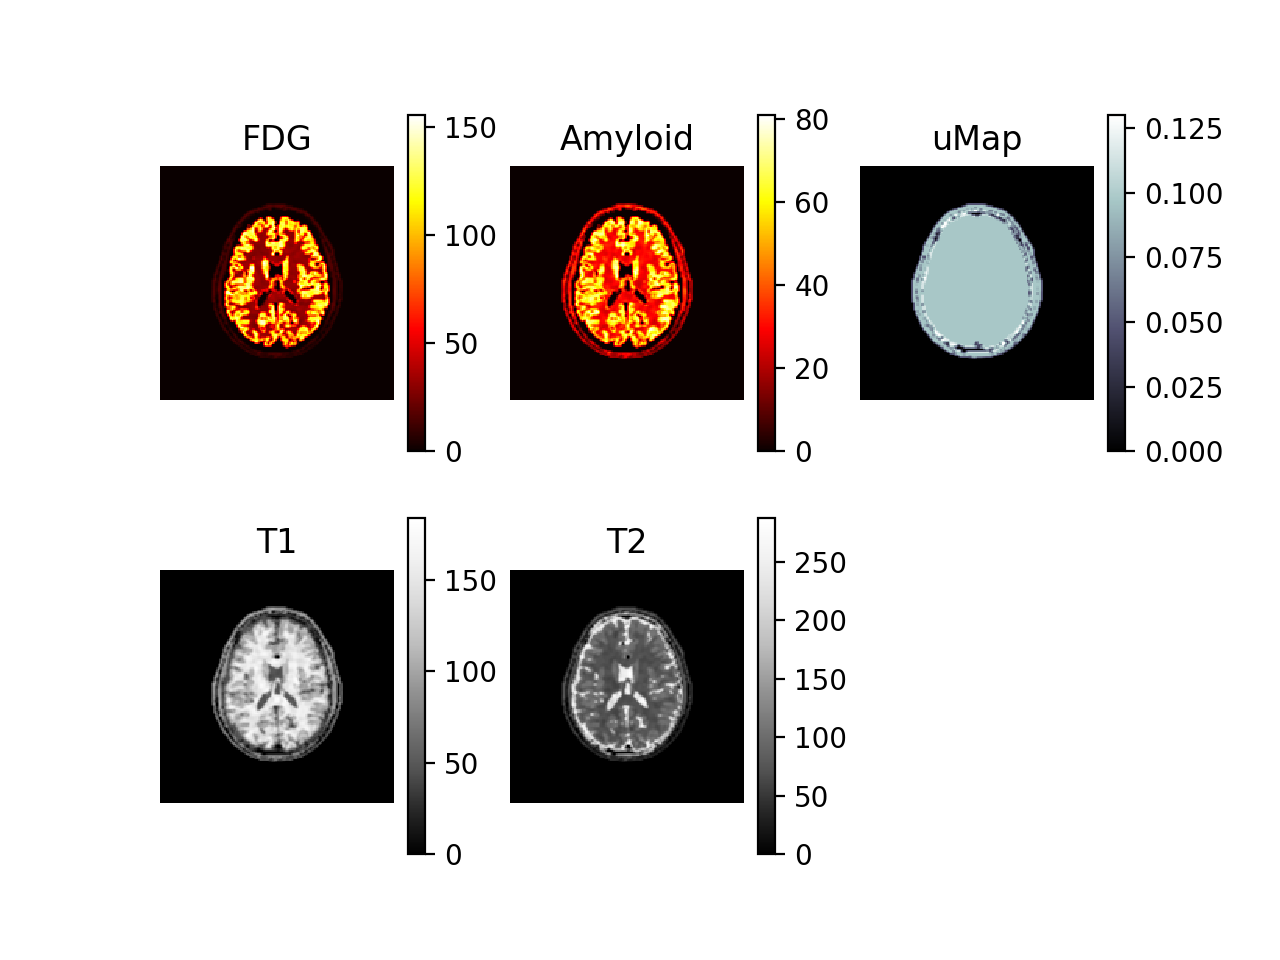

In [5]:
plt.figure();
slice_show = FDG.as_array().shape[0]//2
subplot_([2,3,1],FDG.as_array() [slice_show,:,:],'FDG'    ,cmap="hot")
subplot_([2,3,2],amyl.as_array()[slice_show,:,:],'Amyloid',cmap="hot")
subplot_([2,3,3],uMap.as_array()[slice_show,:,:],'uMap'   ,cmap="bone")
subplot_([2,3,4],T1.as_array()  [slice_show,:,:],'T1'     ,cmap="Greys_r")
subplot_([2,3,5],T2.as_array()  [slice_show,:,:],'T2'     ,cmap="Greys_r")

In [6]:
def get_acquisition_model(uMap, templ_sino):
      
    #%% create acquisition model
    am = pet.AcquisitionModelUsingRayTracingMatrix()
    am.set_num_tangential_LORs(5)

    # Set up sensitivity due to attenuation
    asm_attn = pet.AcquisitionSensitivityModel(uMap, am)
    asm_attn.set_up(templ_sino)
    bin_eff = pet.AcquisitionData(templ_sino)
    bin_eff.fill(1.0)
    print('applying attenuation (please wait, may take a while)...')
    asm_attn.unnormalise(bin_eff)
    asm_attn = pet.AcquisitionSensitivityModel(bin_eff)

    am.set_acquisition_sensitivity(asm_attn)

    am.set_up(templ_sino,uMap);
    return am

# Function for adding noise
def add_noise(proj_data,noise_factor = 1):
    proj_data_arr = proj_data.as_array() / noise_factor
    # Data should be >=0 anyway, but add abs just to be safe
    proj_data_arr = np.abs(proj_data_arr)
    noisy_proj_data_arr = np.random.poisson(proj_data_arr).astype('float32');
    noisy_proj_data = proj_data.clone()
    noisy_proj_data.fill(noisy_proj_data_arr);
    return noisy_proj_data

In [8]:
am = get_acquisition_model(uMap, templ_sino)

# FDG
sino_FDG = am.forward(FDG)
sino_FDG.write("FDG_sino")
sino_FDG_noisy = add_noise(sino_FDG,1000)
sino_FDG_noisy.write("FDG_sino_noisy")

# Amyloid
sino_amyl = am.forward(amyl)
sino_amyl.write("amyl_sino")
sino_amyl_noisy = add_noise(sino_amyl,1000)
sino_amyl_noisy.write("amyl_sino_noisy")

applying attenuation (please wait, may take a while)...


In [9]:
def PowerMethod(operator, iterations, x_init=None):
    '''Power method to calculate iteratively the Lipschitz constant
    
    :param operator: input operator
    :type operator: :code:`LinearOperator`
    :param iterations: number of iterations to run
    :type iteration: int
    :param x_init: starting point for the iteration in the operator domain
    :returns: tuple with: L, list of L at each iteration, the data the iteration worked on.
    '''
    
    # Initialise random
    if x_init is None:
        x0 = operator.domain_geometry().allocate('random')
    else:
        x0 = x_init.copy()
        
    x1 = operator.domain_geometry().allocate()
    y_tmp = operator.range_geometry().allocate()
    s = []
    # Loop
    i = 0
    while i < iterations:
        operator.direct(x0,out=y_tmp)
        operator.adjoint(y_tmp,out=x1)
        x1norm = x1.norm()
        if hasattr(x0, 'squared_norm'):
            s.append( x1.dot(x0) / x0.squared_norm() )
        else:
            x0norm = x0.norm()
            s.append( x1.dot(x0) / (x0norm * x0norm) ) 
        x1.multiply((1.0/x1norm), out=x0)
        print ("current squared norm: {}".format(s[-1]))
        i += 1
        #if i == iterations:
            #cont=input("Continue with {} iterations?[y/n]".format(iterations))
            #if cont == 'y':
               # i = 0
    return np.sqrt(s[-1]), [np.sqrt(si) for si in s], x0

normK = PowerMethod(am, 5)[0]

current squared norm: 55770.3040388172
current squared norm: 128098.671875
current squared norm: 134513.390625
current squared norm: 137296.609375
current squared norm: 138613.953125


In [10]:
from cil.optimisation.functions import KullbackLeibler
from cil.optimisation.algorithms import PDHG

In [22]:
alpha = 1
F = KullbackLeibler(b=sino_FDG_noisy)
G = FGP_dTV(reference = T1, alpha = alpha,
                    max_iteration = 100, tolerance = 1e-6, isotropic=1, nonnegativity = 1, eta=0.01, device='cpu')
K = am.get_linear_acquisition_model()

In [23]:
sigma = 1./normK
tau = 1./normK
pdhg = PDHG(f = F, g = G, operator = am, tau = tau, sigma = sigma,
            max_iteration = 10,
            update_objective_interval = 2)
pdhg.run(verbose = 2)   

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap


/home/sirfuser/miniconda3/envs/mcir/lib/python3.7/site-packages/cil/plugins/ccpi_regularisation/functions/regularisers.py:208: UserWarning: FGP_dTV: the __call__ method is not implemented. Returning NaN.
  warnings.warn("{}: the __call__ method is not implemented. Returning NaN.".format(self.__class__.__name__))
/home/sirfuser/miniconda3/envs/mcir/lib/python3.7/site-packages/cil/plugins/ccpi_regularisation/functions/regularisers.py:231: UserWarning: FGP_dTV: the convex_conjugate method is not implemented. Returning NaN.
  warnings.warn("{}: the convex_conjugate method is not implemented. Returning NaN.".format(self.__class__.__name__))


        0         10         0.000                                            


/home/sirfuser/miniconda3/envs/mcir/lib/python3.7/site-packages/cil/plugins/ccpi_regularisation/functions/regularisers.py:208: UserWarning: FGP_dTV: the __call__ method is not implemented. Returning NaN.
  warnings.warn("{}: the __call__ method is not implemented. Returning NaN.".format(self.__class__.__name__))
/home/sirfuser/miniconda3/envs/mcir/lib/python3.7/site-packages/cil/plugins/ccpi_regularisation/functions/regularisers.py:231: UserWarning: FGP_dTV: the convex_conjugate method is not implemented. Returning NaN.
  warnings.warn("{}: the convex_conjugate method is not implemented. Returning NaN.".format(self.__class__.__name__))


        2         10        28.543                                            
        4         10        30.264                                            
        6         10        30.771                                            
        8         10        31.078                                            
       10         10        31.221                                            
----------------------------------------------------------------------------
       10         10        31.221                                            
Stop criterion has been reached.



In [24]:
pdhg.solution.shape

(127, 150, 150)

In [25]:
from cil.utilities.display import plotter2D
from cil.utilities.jupyter import islicer
%matplotlib inline
islicer(pdhg.solution, direction=0, cmap="inferno")


interactive(children=(IntSlider(value=63, continuous_update=False, description='X', max=126), FloatRangeSlider…

IntSlider(value=63, continuous_update=False, description='X', max=126)

In [26]:
image = sino_FDG_noisy.create_uniform_image(0., (127,150,150))

In [27]:
# setup OSEM
obj_fun = pet.make_Poisson_loglikelihood(sino_FDG_noisy)
obj_fun.set_acquisition_model(am)

recon = pet.OSMAPOSLReconstructor()
recon.set_objective_function(obj_fun)
recon.set_num_subsets(7)
recon.set_num_subiterations(58)
# run OSEM
recon.set_up(image)

# set the initial image estimate
recon.set_current_estimate(image)

recon.process()
osem_recon = recon.get_output()

In [28]:
# show OSEM recon
islicer(osem_recon, direction=0, cmap="inferno")

interactive(children=(IntSlider(value=63, continuous_update=False, description='X', max=126), FloatRangeSlider…

IntSlider(value=63, continuous_update=False, description='X', max=126)